In [2]:
import pandas as pd

# List of participant IDs and number of files per participant
participants = [1, 2, 3, 4]  # 4 participants

# Function to load data and split into train, validation, and test
def load_and_split_eda_data(participants):
    train_data = []
    val_data = []
    test_data = []

    for participant in participants:
        for file_num in range(1, 11):  # Assuming 10 files per participant
            file_path = f'EDA_{participant}_{file_num}.csv'  # Adjust path
            df = pd.read_csv(file_path, skiprows=3, header=None)
            df.columns = ['EDA']
            df['Participant'] = participant
            df['File'] = file_num

            # Split the data according to the file number
            if file_num <= 8:
                train_data.append(df)
            elif file_num == 9:
                val_data.append(df)
            elif file_num == 10:
                test_data.append(df)

    # Concatenate all the files into one dataframe for each split
    train_data = pd.concat(train_data, ignore_index=True)
    val_data = pd.concat(val_data, ignore_index=True)
    test_data = pd.concat(test_data, ignore_index=True)

    return train_data, val_data, test_data

# Load and split the data
train_data, val_data, test_data = load_and_split_eda_data(participants)

# Check the data splits
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (80254, 3)
Validation data shape: (11372, 3)
Test data shape: (10106, 3)


In [3]:
# Placeholder function to extract phasic and tonic components
def extract_phasic_tonic(eda_signal):
    phasic_component = eda_signal.rolling(window=20).mean()  # Simplified example
    tonic_component = eda_signal - phasic_component  # Simplified example
    return phasic_component, tonic_component

# Apply phasic and tonic extraction
train_data['Phasic'], train_data['Tonic'] = extract_phasic_tonic(train_data['EDA'])
val_data['Phasic'], val_data['Tonic'] = extract_phasic_tonic(val_data['EDA'])
test_data['Phasic'], test_data['Tonic'] = extract_phasic_tonic(test_data['EDA'])

# Drop any NaN values due to rolling operations
train_data.dropna(inplace=True)
val_data.dropna(inplace=True)
test_data.dropna(inplace=True)


In [4]:
# Function to create lagged features
def create_features(df, n_lags=5):
    for lag in range(1, n_lags + 1):
        df[f'Phasic_lag_{lag}'] = df['Phasic'].shift(lag)
        df[f'Tonic_lag_{lag}'] = df['Tonic'].shift(lag)
    df.dropna(inplace=True)  # Drop rows with NaN values after shifting
    return df

# Apply feature engineering to train, validation, and test sets
train_data = create_features(train_data)
val_data = create_features(val_data)
test_data = create_features(test_data)

# Define features and target
features = [col for col in train_data.columns if 'lag' in col]
target = 'EDA'


In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])
test_data[features] = scaler.transform(test_data[features])

# Function to prepare data for LSTM (converting into 3D sequences)
def create_lstm_data(df, target, features, time_steps=10):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df[features].iloc[i:i+time_steps].values)
        y.append(df[target].iloc[i+time_steps])
    return np.array(X), np.array(y)

# Create LSTM sequences
time_steps = 10
X_train, y_train = create_lstm_data(train_data, target, features, time_steps)
X_val, y_val = create_lstm_data(val_data, target, features, time_steps)
X_test, y_test = create_lstm_data(test_data, target, features, time_steps)

print("LSTM data shapes:", X_train.shape, X_val.shape, X_test.shape)


LSTM data shapes: (80220, 10, 10) (11338, 10, 10) (10072, 10, 10)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - loss: 0.0280 - val_loss: 0.0016
Epoch 2/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0052 - val_loss: 8.9860e-04
Epoch 3/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 4/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 5/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 6/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 7/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 8/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 0.0036 - val_loss: 9.0513e-04
Epoch 9/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 10/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0034 - val_loss: 9.3112e-04
Epoch 11/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0035 - val_loss: 9.0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,355 (380.30 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,904 (253.54 KB)

In [12]:
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, recall_score, roc_auc_score

# Predict on validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Evaluate the model on val set
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"val RMSE: {rmse_val}")

# Convert predictions to binary for classification metrics
y_val_pred_binary = np.where(y_val_pred > y_val.mean(), 1, 0)
y_val_binary = np.where(y_val > y_val.mean(), 1, 0)

accuracy_val = accuracy_score(y_val_binary, y_val_pred_binary)
f1_val = f1_score(y_val_binary, y_val_pred_binary)
sensitivity_val = recall_score(y_val_binary, y_val_pred_binary)
auroc_val = roc_auc_score(y_val_binary, y_val_pred_binary)

print(f"val Accuracy: {accuracy_val}")
print(f"val F1 Score: {f1_val}")
print(f"val Sensitivity: {sensitivity_val}")
print(f"val AUROC: {auroc_val}")

# Evaluate the model on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {rmse_test}")

# Convert predictions to binary for classification metrics
y_test_pred_binary = np.where(y_test_pred > y_test.mean(), 1, 0)
y_test_binary = np.where(y_test > y_test.mean(), 1, 0)

accuracy_test = accuracy_score(y_test_binary, y_test_pred_binary)
f1_test = f1_score(y_test_binary, y_test_pred_binary)
sensitivity_test = recall_score(y_test_binary, y_test_pred_binary)
auroc_test = roc_auc_score(y_test_binary, y_test_pred_binary)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Sensitivity: {sensitivity_test}")
print(f"Test AUROC: {auroc_test}")


355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
val RMSE: 0.031331217699961986
val Accuracy: 0.999382607161757
val F1 Score: 0.9987899740708729
val Sensitivity: 0.9982722874913614
val AUROC: 0.9990177164600341
Test RMSE: 0.06377643724377711
Test Accuracy: 0.999801429706116
Test F1 Score: 0.9996156802459647
Test Sensitivity: 0.9992316557817903
Test AUROC: 0.9996158278908951


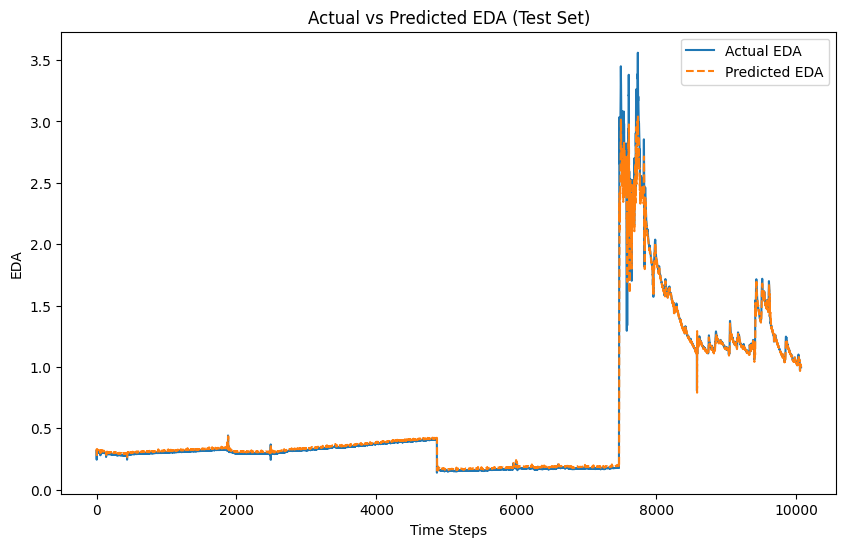

In [8]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual EDA')
plt.plot(y_test_pred, label='Predicted EDA', linestyle='dashed')
plt.title('Actual vs Predicted EDA (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('EDA')
plt.legend()
plt.show()


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


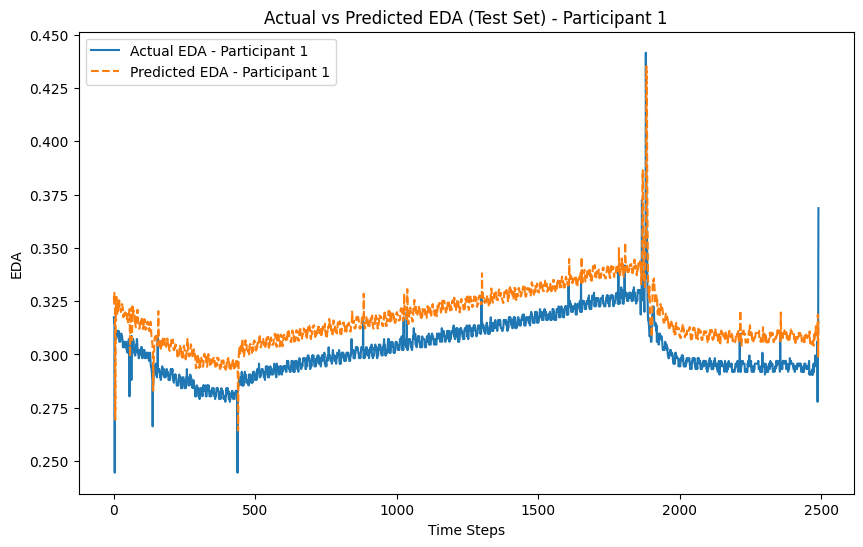

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


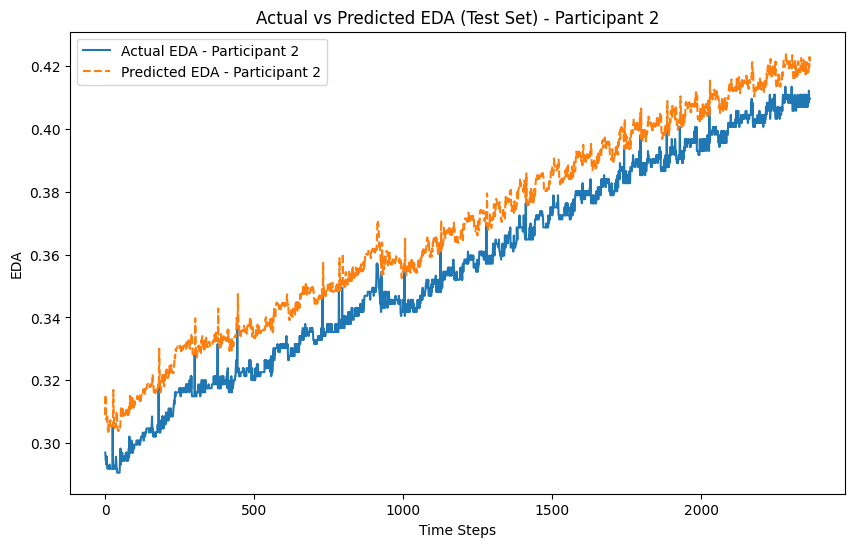

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


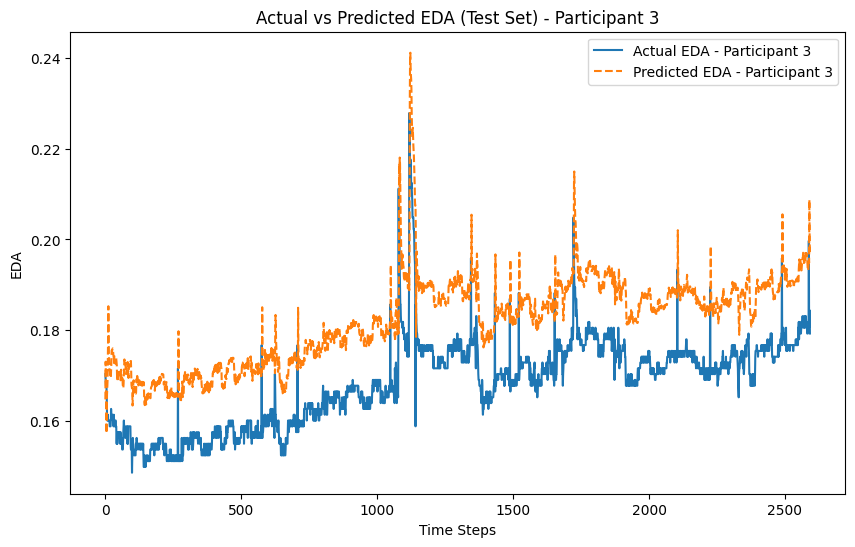

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


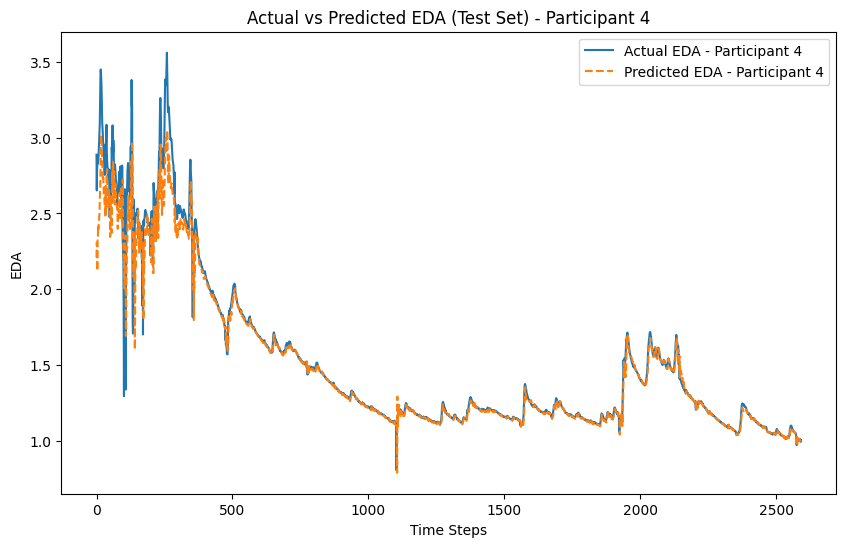

In [11]:
# Function to create LSTM data per participant for plotting
def create_lstm_data_by_participant(df, target, features, time_steps=10):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df[features].iloc[i:i+time_steps].values)
        y.append(df[target].iloc[i+time_steps])
    return np.array(X), np.array(y)

# Extract the test data for a specific participant and plot actual vs predicted
def plot_test_results_by_participant(test_data, model, participants, features, target, time_steps=10):
    for participant in participants:
        # Filter the test data for the current participant
        participant_test_data = test_data[test_data['Participant'] == participant]

        # Create LSTM input for this participant
        X_participant, y_participant = create_lstm_data_by_participant(participant_test_data, target, features, time_steps)

        # Predict for this participant
        y_participant_pred = model.predict(X_participant)

        # Plot actual vs predicted for the participant
        plt.figure(figsize=(10, 6))
        plt.plot(y_participant, label=f'Actual EDA - Participant {participant}')
        plt.plot(y_participant_pred, label=f'Predicted EDA - Participant {participant}', linestyle='dashed')
        plt.title(f'Actual vs Predicted EDA (Test Set) - Participant {participant}')
        plt.xlabel('Time Steps')
        plt.ylabel('EDA')
        plt.legend()
        plt.show()

# Now call the function to plot for each participant
plot_test_results_by_participant(test_data, model, participants, features, target, time_steps)

